In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale 

### Capital Bikeshare Data
https://ride.capitalbikeshare.com/system-data

We deal with data from Jan to Apr in 2022

In [2]:
# read csv files
df_Jan=pd.read_csv('Data/202201-capitalbikeshare-tripdata.csv')
df_Feb=pd.read_csv('Data/202202-capitalbikeshare-tripdata.csv')
df_Mar=pd.read_csv('Data/202203-capitalbikeshare-tripdata.csv')
df_Apr=pd.read_csv('Data/202204-capitalbikeshare-tripdata.csv')

In [3]:
# concat data
df=pd.concat([df_Jan,df_Feb,df_Mar,df_Apr])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 828621 entries, 0 to 310434
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ride_id             828621 non-null  object 
 1   rideable_type       828621 non-null  object 
 2   started_at          828621 non-null  object 
 3   ended_at            828621 non-null  object 
 4   start_station_name  792027 non-null  object 
 5   start_station_id    792027 non-null  float64
 6   end_station_name    786251 non-null  object 
 7   end_station_id      786251 non-null  float64
 8   start_lat           828621 non-null  float64
 9   start_lng           828621 non-null  float64
 10  end_lat             827170 non-null  float64
 11  end_lng             827170 non-null  float64
 12  member_casual       828621 non-null  object 
dtypes: float64(6), object(7)
memory usage: 88.5+ MB


In [4]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member


### Be careful when dealing with time and date

In [5]:
# Transform time to date ONLY
df['started_at_date'] = pd.to_datetime(df['started_at']).dt.date
df['ended_at_date'] = pd.to_datetime(df['ended_at']).dt.date

In [6]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,started_at_date,ended_at_date
0,1B4445D591115BD9,classic_bike,2022-01-06 18:39:28,2022-01-06 18:43:03,Monroe Ave & Leslie Ave,31087.0,Potomac Ave & Main Line Blvd,31910.0,38.820932,-77.053096,38.822738,-77.049265,member,2022-01-06,2022-01-06
1,7F4A0E2F03EADEB7,classic_bike,2022-01-31 19:21:22,2022-01-31 19:27:33,14th & L St NW,31283.0,10th & G St NW,31274.0,38.903658,-77.031737,38.898243,-77.026235,member,2022-01-31,2022-01-31
2,30DD8A84164843AD,classic_bike,2022-01-07 15:28:39,2022-01-07 15:31:01,14th & L St NW,31283.0,12th & L St NW,31251.0,38.903658,-77.031737,38.903819,-77.028400,member,2022-01-07,2022-01-07
3,FC67665D7682D0A6,classic_bike,2022-01-27 20:09:25,2022-01-27 20:37:02,New York Ave & Hecht Ave NE,31518.0,Nannie Helen Burroughs & Minnesota Ave NE,31704.0,38.915604,-76.983683,38.901385,-76.941877,casual,2022-01-27,2022-01-27
4,7854F7CC4F631A1E,classic_bike,2022-01-07 16:14:28,2022-01-07 16:16:13,Falls Church City Hall / Park Ave & Little Fal...,32608.0,Pennsylvania Ave & Park Ave,32603.0,38.885434,-77.173605,38.887403,-77.176992,member,2022-01-07,2022-01-07


## For demonstration, we consider GWSB station "22nd & H St NW"
### Students will work with '21st & I St NW' and '21st St & Pennsylvania Ave NW' instead.

### Count daily pickups

In [7]:
# Group and get pickup occurrence for 22nd & H St NW
df_sub1 = df[df['start_station_name']=="21st St & Pennsylvania Ave NW"]
df_grp1 = df_sub1.groupby(['started_at_date','start_station_name']).size()
df_pu=df_grp1.reset_index(name = "pu_ct")
df_pu

,started_at_date,start_station_name,pu_ct
0,2022-01-01,21st St & Pennsylvania Ave NW,5
1,2022-01-02,21st St & Pennsylvania Ave NW,1
2,2022-01-03,21st St & Pennsylvania Ave NW,1
3,2022-01-05,21st St & Pennsylvania Ave NW,3
4,2022-01-06,21st St & Pennsylvania Ave NW,5
...,...,...,...
110,2022-04-26,21st St & Pennsylvania Ave NW,22
111,2022-04-27,21st St & Pennsylvania Ave NW,21
112,2022-04-28,21st St & Pennsylvania Ave NW,23
113,2022-04-29,21st St & Pennsylvania Ave NW,23


### Count daily dropoffs

In [8]:
# Group and get drop off occurrence for 22nd & H St NW
df_sub2 = df[df['end_station_name']=="21st St & Pennsylvania Ave NW"]
df_grp2 = df_sub2.groupby(['ended_at_date','end_station_name']).size()
df_do=df_grp2.reset_index(name = "do_ct")
df_do

,ended_at_date,end_station_name,do_ct
0,2022-01-01,21st St & Pennsylvania Ave NW,4
1,2022-01-02,21st St & Pennsylvania Ave NW,3
2,2022-01-03,21st St & Pennsylvania Ave NW,2
3,2022-01-04,21st St & Pennsylvania Ave NW,1
4,2022-01-05,21st St & Pennsylvania Ave NW,4
...,...,...,...
114,2022-04-26,21st St & Pennsylvania Ave NW,29
115,2022-04-27,21st St & Pennsylvania Ave NW,29
116,2022-04-28,21st St & Pennsylvania Ave NW,26
117,2022-04-29,21st St & Pennsylvania Ave NW,34


### Visualize pickups and dropoffs

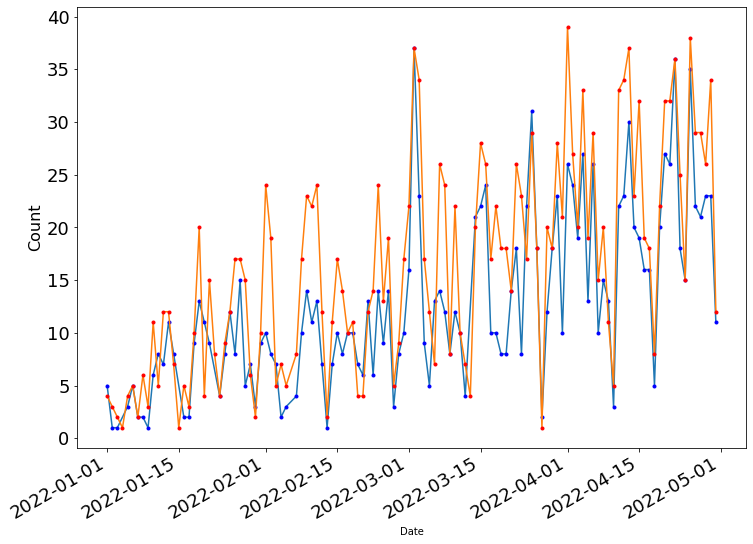

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 9))
ax1.plot_date( df_pu['started_at_date'], df_pu['pu_ct'],linestyle = 'solid',markeredgecolor = 'blue',markerfacecolor = 'blue', markersize = 3)
ax1.plot_date( df_do['ended_at_date'], df_do['do_ct'],linestyle = 'solid',markeredgecolor = 'red',markerfacecolor = 'red', markersize = 3)

ax1.set_xlabel('Date',fontsize=10)
ax1.set_ylabel('Count',fontsize=16)
plt.gcf().autofmt_xdate()

plt.tick_params(labelsize=18)
plt.show()  

## Weather Data

In [10]:
df_weather = pd.read_csv('Data/DC Weather 2022-01-01 to 2022-12-31.csv')

df_weather.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"Washington,DC,USA",2022-01-01,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,...,0.6,0,NaN,2022-01-01T07:26:53,2022-01-01T16:56:53,0.99,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
1,"Washington,DC,USA",2022-01-02,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,...,1.7,1,NaN,2022-01-02T07:27:00,2022-01-02T16:57:43,1.00,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."
2,"Washington,DC,USA",2022-01-03,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,...,0.0,0,NaN,2022-01-03T07:27:05,2022-01-03T16:58:34,0.00,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with a chance...,snow,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,A..."
3,"Washington,DC,USA",2022-01-04,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,...,5.4,6,NaN,2022-01-04T07:27:07,2022-01-04T16:59:27,0.02,Clear,Clear conditions throughout the day.,snow,"KDCA,72405013743,72403793728,D6279,F0198,KADW,..."
4,"Washington,DC,USA",2022-01-05,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,...,2.2,1,NaN,2022-01-05T07:27:08,2022-01-05T17:00:21,0.05,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"KDCA,72405013743,72403793728,F0198,KADW,KDAA,7..."


## Check missing values

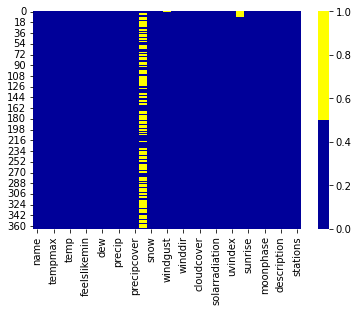

In [11]:
# Date time format 
df_weather['datetime'] = pd.to_datetime(df_weather['datetime']).dt.date

# Use sns heatmap to see whats are the null values.
coln = df_weather.columns[:df_weather.shape[1]]  
colors = ['#000099','#ffff00'] # specify the colors - yellow is missing. blue is not missing.
sns.heatmap(df_weather[coln].isnull(), cmap = sns.color_palette(colors))
plt.show()

## Drop variables of your choice

In [12]:
# Drop unnecessary variables
df_weather=df_weather.drop(columns=['name', 'stations','description','sunrise','sunset','conditions','severerisk','preciptype','windgust'])

## Prepare X and y: Merge weather data with trip data

In [13]:
# Merge with weather data and remove dates and station name

df_m_pu = df_pu.merge(df_weather, left_on='started_at_date', right_on='datetime') 
df_m_pu = df_m_pu.drop(columns=['started_at_date','start_station_name','datetime'])#1
df_m_do = df_do.merge(df_weather, left_on='ended_at_date', right_on='datetime') 
df_m_do = df_m_do.drop(columns=['ended_at_date','end_station_name','datetime'])

In [14]:
df_m_do.head()

,do_ct,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon
0,4,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,...,11.4,190.2,1007.2,99.5,6.2,21.4,0.6,0,0.99,rain
1,3,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,...,18.9,290.7,1006.6,91.6,9.6,47.3,1.7,1,1.00,rain
2,2,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,...,22.5,358.5,1019.7,77.2,6.2,6.3,0.0,0,0.00,snow
3,1,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,...,14.1,192.1,1029.7,18.7,9.9,153.2,5.4,6,0.02,snow
4,4,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,...,13.6,195.2,1014.5,82.6,9.9,63.5,2.2,1,0.05,partly-cloudy-day


# Demo: train linear models

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [16]:
# pickup
y = df_m_do['do_ct']
X = df_m_do.drop('do_ct',axis=1)
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
0,63.5,54.1,58.3,63.5,54.1,58.3,56.0,92.1,0.448,100,...,99.5,6.2,21.4,0.6,0,0.99,0,1,0,0
1,62.7,47.8,57.5,62.7,42.0,57.0,51.6,81.6,0.124,100,...,91.6,9.6,47.3,1.7,1,1.00,0,1,0,0
2,46.0,26.1,32.7,39.4,14.3,23.0,26.6,78.7,0.889,100,...,77.2,6.2,6.3,0.0,0,0.00,0,0,1,0
3,34.0,25.3,29.4,33.7,16.0,24.0,19.2,65.7,0.000,0,...,18.7,9.9,153.2,5.4,6,0.02,0,0,1,0
4,40.8,28.1,35.8,37.2,19.8,29.5,29.0,76.3,0.000,0,...,82.6,9.9,63.5,2.2,1,0.05,1,0,0,0


In [17]:
X_train,X_test, y_train,y_test = train_test_split(X,y, test_size=0.4, random_state = 200)

## Linear Regression

In [18]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train) 
y_pred = linear_regressor.predict(X_test)

In [19]:
print(pd.Series(linear_regressor.coef_.flatten(), index=X_train.columns))

tempmax                    0.961719
tempmin                    1.469004
temp                      -5.040983
feelslikemax              -0.695351
feelslikemin              -0.791879
feelslike                  2.046496
dew                        2.516393
humidity                  -1.142848
precip                    15.216122
precipprob                 0.106878
precipcover               -0.173749
snow                      -1.289838
snowdepth                  1.328512
windspeed                 -0.547111
winddir                    0.012148
sealevelpressure           0.118925
cloudcover                -0.016294
visibility                 0.228567
solarradiation            -0.140639
solarenergy                2.551903
uvindex                    0.262377
moonphase                  0.094145
icon_partly-cloudy-day    -1.357301
icon_rain                 -8.124269
icon_snow                 -4.239596
icon_wind                 13.721166
dtype: float64


In [20]:
mse_lr = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_lr}")

MSE is 55.297


## LASSO CV

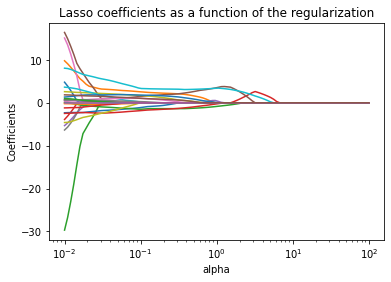

In [21]:
alphas = 10**np.linspace(-2,2,100)

lasso = Lasso()
coefs = []

for a in alphas:
    lasso.set_params(alpha=a, max_iter=10000) # increase iterations for optimization of coefficients
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')
# plt.legend(list(X_train.columns), loc='best')

plt.title('Lasso coefficients as a function of the regularization');

In [22]:
# find the best alpha via CV with selected scoring metric
lassocv = LassoCV(alphas=alphas, max_iter=10000)
lassocv.fit(scale(X_train), y_train)

print('The best alpha from LassoCV:', lassocv.alpha_)

The best alpha from LassoCV: 1.0476157527896652


In [23]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
print('The coefficients are:')
print(pd.Series(lasso.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.000000
tempmin                   0.000000
temp                      0.000000
feelslikemax              0.000000
feelslikemin              0.327060
feelslike                 3.599647
dew                       0.000000
humidity                 -0.000000
precip                    0.000000
precipprob               -0.000000
precipcover              -0.000000
snow                     -0.000000
snowdepth                -0.807590
windspeed                -0.205237
winddir                  -0.000000
sealevelpressure         -0.000000
cloudcover                0.000000
visibility               -0.000000
solarradiation            0.000000
solarenergy               3.418568
uvindex                   0.000000
moonphase                 0.000000
icon_partly-cloudy-day    0.000000
icon_rain                -0.000000
icon_snow                -0.000000
icon_wind                 0.000000
dtype: float64


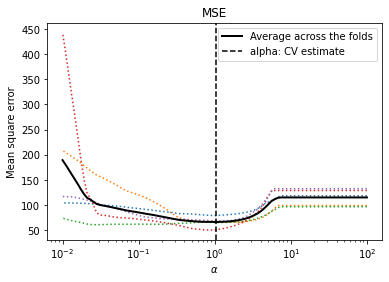

In [24]:
plt.semilogx(lassocv.alphas_, lassocv.mse_path_, linestyle=":")
plt.plot(
    lassocv.alphas_,
    lassocv.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lassocv.alpha_, linestyle="--", color="black", label="alpha: CV estimate")


plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
plt.title("MSE")
plt.show()

In [25]:
y_pred=lasso.predict(scale(X_test.values))
mse_lasso = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_lasso}")

MSE is 44.019


## Ridge CV

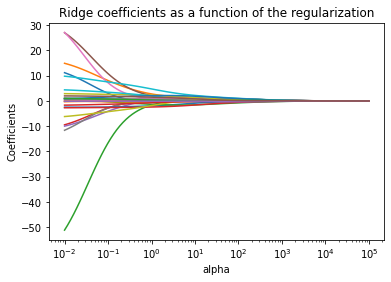

In [26]:
alphas = 10**np.linspace(-2,5,100)

ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(scale(X_train), y_train)
    coefs.append(ridge.coef_)

ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim())  
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients')


plt.title('Ridge coefficients as a function of the regularization');

In [27]:
# standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

In [28]:
# set a large alpha to get smaller coefficients
ridge = Ridge(alpha=1000) 
ridge.fit(scaler.transform(X_train), y_train)

print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.295143
tempmin                   0.262055
temp                      0.279468
feelslikemax              0.297632
feelslikemin              0.265070
feelslike                 0.286310
dew                       0.200909
humidity                 -0.069020
precip                   -0.011522
precipprob               -0.078239
precipcover              -0.098449
snow                     -0.141635
snowdepth                -0.199560
windspeed                -0.105978
winddir                  -0.032831
sealevelpressure         -0.020416
cloudcover               -0.033252
visibility                0.050916
solarradiation            0.205365
solarenergy               0.296557
uvindex                   0.270233
moonphase                 0.036803
icon_partly-cloudy-day    0.127306
icon_rain                -0.019229
icon_snow                -0.166372
icon_wind                 0.020344
dtype: float64


In [29]:
# find the best alpha via CV with selected scoring metric
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error')
ridgecv.fit(scale(X_train), y_train)

print('The best alpha from RidgeCV:', ridgecv.alpha_)

The best alpha from RidgeCV: 91.11627561154887


In [30]:
# with the best alpha
ridge.set_params(alpha=ridgecv.alpha_)
ridge.fit(scale(X_train), y_train)
print('The coefficients are:')
print(pd.Series(ridge.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.688827
tempmin                   0.661080
temp                      0.628574
feelslikemax              0.707139
feelslikemin              0.645375
feelslike                 0.690052
dew                       0.421286
humidity                 -0.264895
precip                    0.363174
precipprob               -0.148959
precipcover              -0.253318
snow                     -0.252407
snowdepth                -0.790958
windspeed                -0.592003
winddir                  -0.241460
sealevelpressure          0.003398
cloudcover                0.024008
visibility                0.043181
solarradiation            0.591483
solarenergy               1.072380
uvindex                   0.979593
moonphase                 0.099427
icon_partly-cloudy-day    0.226299
icon_rain                -0.111539
icon_snow                -0.248384
icon_wind                 0.170422
dtype: float64


In [31]:
y_pred=ridge.predict(scale(X_test.values))
mse_ridge = round(mean_squared_error(y_test, y_pred),3)
print(f"MSE is {mse_ridge}")

MSE is 45.02


## Elastic net

In [32]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

ENcv = ElasticNetCV(alphas=None, cv=10, max_iter=10000) # default l1_ratio=0.5
ENcv.fit(scale(X_train), y_train)

print('The best alpha from ElasticNetCV:', ENcv.alpha_)

The best alpha from ElasticNetCV: 1.0416537784732232


In [33]:
# with the best alpha
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)


EN=ElasticNet()
EN.set_params(alpha=ENcv.alpha_)
EN.fit(scale(X_train), y_train)

print('The coefficients are:')
print(pd.Series(EN.coef_.flatten(), index=X_train.columns))

The coefficients are:
tempmax                   0.714861
tempmin                   0.676185
temp                      0.602646
feelslikemax              0.751377
feelslikemin              0.674009
feelslike                 0.755253
dew                       0.100810
humidity                 -0.000000
precip                    0.000000
precipprob               -0.000000
precipcover              -0.000000
snow                     -0.024925
snowdepth                -0.980634
windspeed                -0.611327
winddir                  -0.033402
sealevelpressure         -0.000000
cloudcover                0.000000
visibility                0.000000
solarradiation            0.315626
solarenergy               1.484841
uvindex                   1.190868
moonphase                 0.000000
icon_partly-cloudy-day    0.106373
icon_rain                -0.000000
icon_snow                -0.068391
icon_wind                 0.000000
dtype: float64


In [34]:
y_pred = EN.predict(scale(X_test.values))
mse_EN = round(mean_squared_error(y_test, y_pred), 3)
print(f"Test MSE for ElasticNet is {mse_EN}")

Test MSE for ElasticNet is 44.231


## KNN

In [35]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
import matplotlib.pyplot as plt
mse_train = [-1]*30
mse_test = [-1]*30
for K in range(30):
    model = neighbors.KNeighborsRegressor(n_neighbors = K+1)
    model.fit(X_train, y_train)  #fit the model
    mse_train[K] = mean_squared_error(y_train, model.predict(X_train))
    mse_test[K] = mean_squared_error(y_test, model.predict(X_test)) 


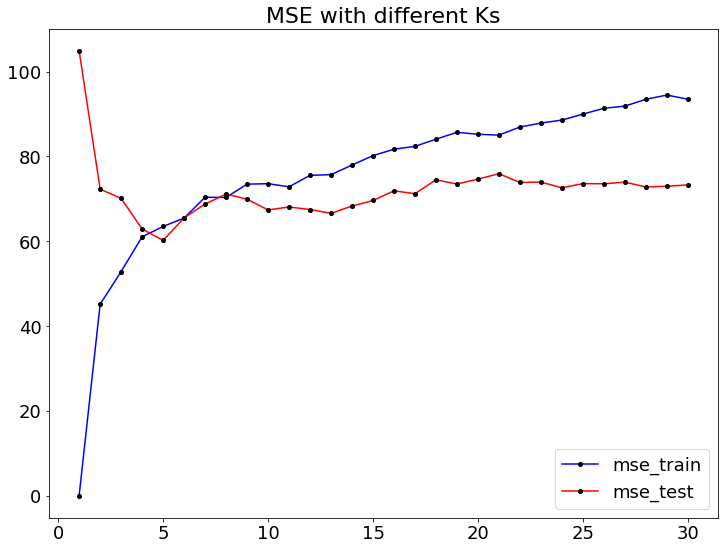

In [36]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [37]:
# optimal k
np.argmin(mse_test)+1

5

In [38]:
# optimal MSE
min(mse_test)

60.203333333333326

### KNN CV

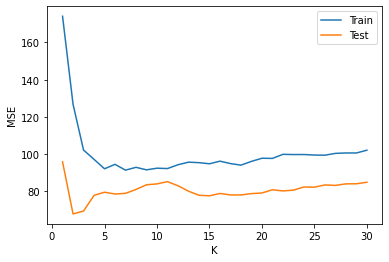

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
import numpy as np

mse_train = []
mse_test = []
for K in range(1, 31):
    knn = KNeighborsRegressor(n_neighbors=K)
    scores_train = -cross_val_score(knn, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores_test = -cross_val_score(knn, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    mse_train.append(np.mean(scores_train))
    mse_test.append(np.mean(scores_test))

plt.plot(range(1, 31), mse_train, label='Train')
plt.plot(range(1, 31), mse_test, label='Test')
plt.xlabel('K')
plt.ylabel('MSE')
plt.legend()
plt.show()

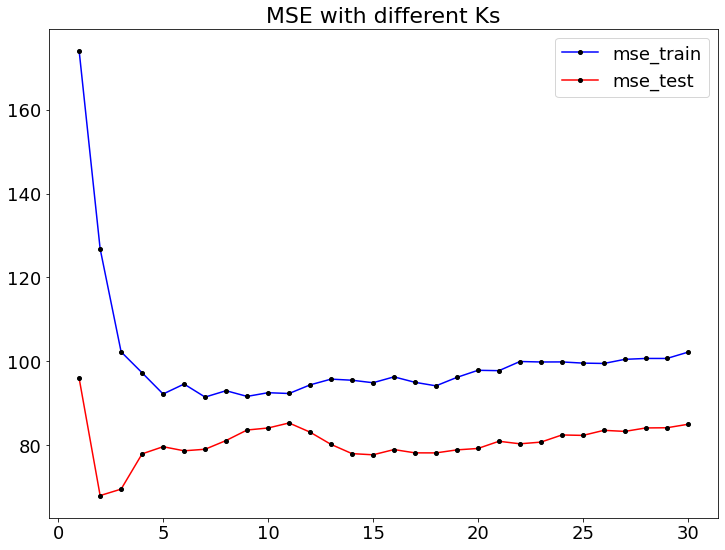

In [40]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 9))
plt.plot(np.arange(30)+1, mse_train,  color = 'blue', marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black',label = 'mse_train')
plt.plot(np.arange(30)+1, mse_test,  color = 'red',marker = '.', markersize = 8, markeredgecolor = 'black', markerfacecolor = 'black', label = 'mse_test')
plt.legend(fontsize=18)
plt.title('MSE with different Ks', fontsize=22)
plt.tick_params(labelsize=18)
plt.show()

In [41]:
# optimal k
np.argmin(mse_test)+1

2

In [42]:
# optimal MSE
min(mse_test)

67.91388888888888

## You will try other methods (e.g., KNN) and tune hyperparameters when necessary

In [51]:
import pandas as pd

# Define data
mse_values = [mse_lr, min(mse_test), mse_lasso, mse_ridge, mse_EN]
hyperparameters = [
    'N/A',
    'k = 2',
      lassocv.alpha_,
    ridgecv.alpha_,
    ENcv.alpha_
]
model_names = ['Linear Regression', 'KNN CV', 'Lasso CV', 'Ridge CV', 'Elastic Net CV']

# Create table
df = pd.DataFrame({
    'Model': model_names,
    'MSE': mse_values,
    'Hyperparameters': hyperparameters
})

# Print table
print(df)                                                   

               Model        MSE Hyperparameters
0  Linear Regression  55.297000             N/A
1             KNN CV  67.913889           k = 2
2           Lasso CV  44.019000        1.047616
3           Ridge CV  45.020000       91.116276
4     Elastic Net CV  44.231000        1.041654


### Scenario 1

In [44]:
X_test.iloc[[1]]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
84,44.9,33.9,40.7,36.4,24.2,32.5,19.3,42.4,0.0,0,...,79.3,9.9,81.1,6.9,5,0.88,1,0,0,0


In [45]:
scaler.transform(X_test.iloc[[1]])

array([[-0.76524996, -0.35923478, -0.454079  , -1.03504498, -0.55064047,
        -0.65637506, -0.78240815, -1.00858269, -0.3415302 , -0.60447052,
        -0.46328328, -0.27424623, -0.2893051 ,  1.38092614,  0.92952124,
        -1.20541338,  0.65180732,  0.46810417, -0.47196163, -0.38530091,
        -0.12868679,  1.03053617,  0.73720978, -0.51754917, -0.38100038,
        -0.11952286]])

In [46]:
y_pred1 = lasso.predict(scaler.transform(X_test.iloc[[1]]))
print(y_pred1)


[13.41417882]


In [47]:
y_test.iloc[[1]]

84    1
Name: do_ct, dtype: int64

### Scenario 2

In [48]:
X_test.iloc[[2]]

,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,precipprob,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,moonphase,icon_partly-cloudy-day,icon_rain,icon_snow,icon_wind
53,42.9,33.1,36.4,34.8,24.7,29.4,26.4,68.9,0.152,100,...,99.3,7.5,15.4,1.3,0,0.79,0,1,0,0


In [49]:
y_pred2 = lasso.predict(scaler.transform(X_test.iloc[[2]]))
print(y_pred2)

[8.44743406]


In [50]:
y_test.iloc[[2]]

53    13
Name: do_ct, dtype: int64